### 使用 webrtcvad 去除聲音中 空白的部份
sample rate support 16000 32000 48000  
audio channel mono  
使用 webrtcvad sndhdr  
pip3 install -U webrtcvad  
webrtcvad sample code   
https://github.com/wiseman/py-webrtcvad/blob/master/example.py  參考這個程式改的
vad mode 可以用 1,或2 的效果 比較好


In [7]:
import collections
import contextlib
import sys
import wave
import os,webrtcvad,sndhdr
import webrtcvad
class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration
        self.is_speech=False
        
def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000,48000)
        pcm_data = wf.readframes(wf.getnframes())
    return pcm_data, sample_rate        
def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)
def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n        
def speechdetect(audioframes,sampling_rate,my_vad):
    '''
    calcuate speech ratio of a wave file
    '''
    count_isspeech=0
    for frame in audioframes:
        frame.is_speech=my_vad.is_speech(frame.bytes,sampling_rate)
        if frame.is_speech:
            count_isspeech += 1   
    speechrate=count_isspeech/len(audioframes)
    return speechrate
def remove_non_voice(audioframes):
    newaudio =[]
    lodlen=len(audioframes)
    audioframes.reverse()
    while audioframes:
        frame=audioframes.pop()
        if frame.is_speech:
            newaudio.append(frame) 
    newaudio=list(newaudio)
    print("there",lodlen,len(newaudio))
    audiostream= b'\x00\x00' 
    if newaudio:
        #yield b''.join([f.bytes for f in newaudio]) 
        audiostream=b''.join([f.bytes for f in newaudio]) 
    return audiostream

def trimvoice(fullfilename,vad_duration_ms,my_vad=webrtcvad.Vad(1)):
    trimaudio=b'\x00\x00'
    audio, sample_rate = read_wave(fullfilename)
    frames = frame_generator(vad_duration_ms, audio, sample_rate)
    frames = list(frames)
    speechrate=speechdetect(frames,sample_rate,my_vad)
    if speechrate<0.9:
        trimaudio=remove_non_voice(frames)

    return sample_rate,speechrate,trimaudio

In [2]:
vad_duration_ms=10 # support 10 20 and 30 ,160000 10, 32000 20 , 480000  30 
TestFile="/mnt/f/workspace/WELLS_WAV/48KTest.wav"
outputname="/mnt/f/workspace/WELLS_WAV/48KTestTrim.wav"
sample_rate,speechrate,trimaudio=trimvoice(TestFile,vad_duration_ms)
if speechrate< 1.0:
    write_wave(outputname,trimaudio,sample_rate)
print(TestFile,sample_rate,speechrate)

there 856 544
/mnt/f/workspace/WELLS_WAV/48KTest.wav 48000 0.6355140186915887


###  使用者自己定義 Vad 的模式


In [3]:
vad_duration_ms=20
'''
vad_duration_ms
support 10 20 and 30 
160000 10, 32000 20 , 480000  30
''' 
TestFile="/mnt/f/workspace/WELLS_WAV/48KTest.wav"
outputname="/mnt/f/workspace/WELLS_WAV/48KTestTrimUdefmode2.wav"
sample_rate,speechrate,trimaudio=trimvoice(TestFile,vad_duration_ms,my_vad=webrtcvad.Vad(2))
if speechrate< 1.0:
    write_wave(outputname,trimaudio,sample_rate)
print(TestFile,sample_rate,speechrate)

there 428 193
/mnt/f/workspace/WELLS_WAV/48KTest.wav 48000 0.45093457943925236


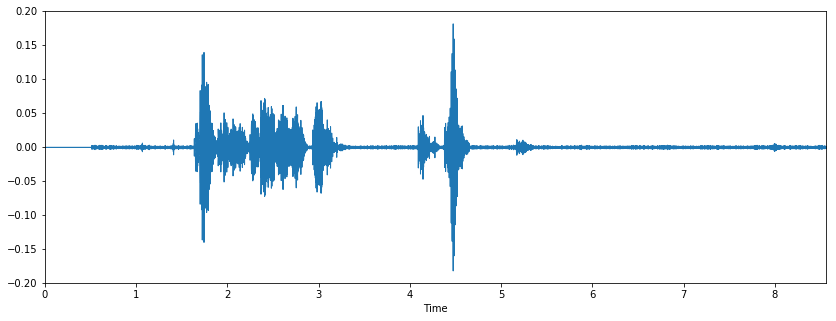

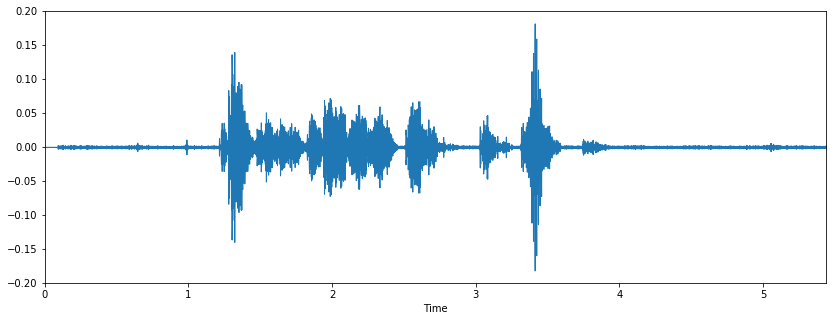

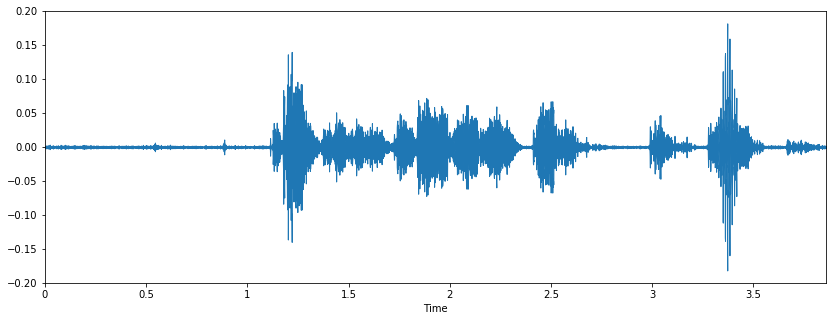

In [6]:


%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa


TestFile="/mnt/f/workspace/WELLS_WAV/48KTest.wav"
outputname="/mnt/f/workspace/WELLS_WAV/48KTestTrim.wav"
outputname1="/mnt/f/workspace/WELLS_WAV/48KTestTrimUdefmode2.wav"
x, sr = librosa.load(TestFile)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
x, sr = librosa.load(outputname)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

x, sr = librosa.load(outputname1)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

